# Leak Location model

## Introduction
This code is part of Fuel leak detection and location based on NPW. 
When a leak occurs, the fluid is forced to change direction suddenly while in motion. Because of this change, two pressure waves are generated and propagated through the fluid, one upstream and the other downstream. This model aims to find a good estimation for the velocity of sound in the fuel.
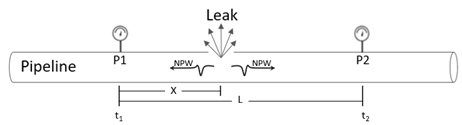

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
import statsmodels.api as sm
from scipy import stats

In [2]:
dataset = pd.read_csv('Data10.csv')

In [3]:
dataset.shape

(1732, 21)

In [4]:
dataset['TimeDiff'] = dataset['TimeDiff']/1000 #convert ms to sec
#dataset['Distance'] = dataset['Distance']*1000 #convert km to m
dataset['Press1'] = dataset['Press1']*100/4095 #convert to bar
dataset['Press2'] = dataset['Press2']*100/4095 #convert to bar

In [5]:
dataset.head()

,File1,PT1,StartTime1,Season,Press1,Site1,minTime1,File2,PT2,StartTime2,...,Site2,minTime2,SITE_N1,SITE_N2,Section,TimeDiff,Distance,V,Summer,Winter
0,123,OSM3004,2020-06-17-10:46:33.586,Summer,34.125240,OSM,1.100000e+11,52,ELR3041,2020-06-17-10:46:36.680,...,ELR,1.100000e+11,4,2,20,5.994,6.30,1051.051051,1,0
1,1308,NHL3001,2019-11-24-09:24:17.300,In between,41.144751,NHL,9.282751e+10,1357,NSH3522,2019-11-24-09:24:37.368,...,NSH,9.282753e+10,9,10,1536,20.028,21.07,1052.027162,0,0
2,1270,ELR3041,2017-05-03-16:51:30.200,In between,44.716484,ELR,1.327993e+10,1271,HFA3029,2017-05-03-16:51:40.30,...,HFA,1.327994e+10,2,1,6,12.150,12.80,1053.497942,0,0
3,1227,HFA3029,2019-07-24-07:28:57.850,Summer,43.757195,HFA,8.245257e+10,732,ELR3041,2019-07-24-07:29:08.240,...,ELR,8.245258e+10,1,2,6,11.950,12.60,1054.393305,1,0
4,1070,HDR3037,2017-03-15-10:29:45.180,In between,39.593830,HDR,9.109823e+09,710,ELR3041,2017-03-15-10:30:23.980,...,ELR,9.109862e+09,7,2,132,38.980,41.15,1055.669574,0,0


In [6]:
dataset.describe()

,File1,Press1,minTime1,File2,Press2,minTime2,SITE_N1,SITE_N2,Section,TimeDiff,Distance,V,Summer,Winter
count,1732.000000,1732.000000,1.732000e+03,1732.000000,1732.000000,1.732000e+03,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000
mean,1323.988453,30.332667,8.575882e+10,1303.881062,27.582335,8.575883e+10,7.343533,7.773095,6388.202079,34.535275,41.487448,1201.771460,0.400115,0.054273
std,811.757749,12.768181,4.267459e+10,843.421370,17.812358,4.267458e+10,3.134810,4.466567,10552.345551,19.338704,23.098110,58.457575,0.490063,0.226620
min,-1.000000,3.148230,1.521810e+06,-1.000000,-0.095188,1.524743e+06,1.000000,1.000000,6.000000,2.135000,2.800000,1051.051051,0.000000,0.000000
25%,910.000000,21.876853,9.282753e+10,694.750000,9.084249,9.282756e+10,7.000000,3.000000,132.000000,16.931000,21.070000,1176.655456,0.000000,0.000000
50%,1244.000000,26.830381,1.090000e+11,1293.000000,26.688326,1.090000e+11,8.000000,8.000000,768.000000,32.210000,38.750000,1202.513150,0.000000,0.000000
75%,1372.000000,37.070095,1.100000e+11,1401.000000,43.378436,1.100000e+11,8.000000,11.000000,16512.000000,46.839500,54.500000,1226.687209,1.000000,0.000000
max,2939.000000,83.573626,1.100000e+11,2940.000000,81.781685,1.100000e+11,15.000000,15.000000,49152.000000,123.870000,152.480000,1496.200760,1.000000,1.000000


In [7]:
df=dataset.loc[:,('Distance','TimeDiff','Press1','Press2','Winter','Summer')]
dataset2=dataset.loc[:,('TimeDiff','Press1','Press2','Winter','Summer')]

#df=dataset.loc[:,('Distance','TimeDiff','V','Press1','Press2','Season_num','Winter','Spring','Summer')]
#dataset2=dataset.loc[:,('TimeDiff','Press1','Press2','Winter','Spring','Summer')]

In [8]:
df

,Distance,TimeDiff,Press1,Press2,Winter,Summer
0,6.30,5.994,34.125240,43.419302,0,1
1,21.07,20.028,41.144751,24.410057,0,0
2,12.80,12.150,44.716484,49.796337,0,0
3,12.60,11.950,43.757195,33.642321,0,1
4,41.15,38.980,39.593830,34.448182,0,0
...,...,...,...,...,...,...
1727,38.30,26.590,23.359498,34.706835,0,0
1728,29.93,20.736,7.749451,3.962393,0,1
1729,29.93,20.704,6.094750,3.513065,0,1
1730,44.80,30.527,42.032344,31.296006,0,0


In [9]:
df.corr()

,Distance,TimeDiff,Press1,Press2,Winter,Summer
Distance,1.000000,0.995526,-0.128517,-0.070399,0.033966,-0.092813
TimeDiff,0.995526,1.000000,-0.127209,-0.062089,0.028489,-0.098788
Press1,-0.128517,-0.127209,1.000000,0.550715,0.463068,-0.179427
Press2,-0.070399,-0.062089,0.550715,1.000000,0.187579,0.029089
Winter,0.033966,0.028489,0.463068,0.187579,1.000000,-0.195644
Summer,-0.092813,-0.098788,-0.179427,0.029089,-0.195644,1.000000


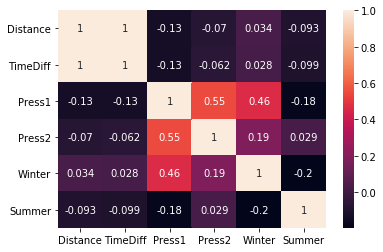

In [10]:
import seaborn as sn
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [11]:
import scipy.stats as stats

stats.f_oneway(dataset['V'][dataset['Season'] == 'Summer'],
               dataset['V'][dataset['Season'] == 'Winter'],
               dataset['V'][dataset['Season'] == 'In between'])

F_onewayResult(statistic=7.360511398275319, pvalue=0.0006560800058863657)

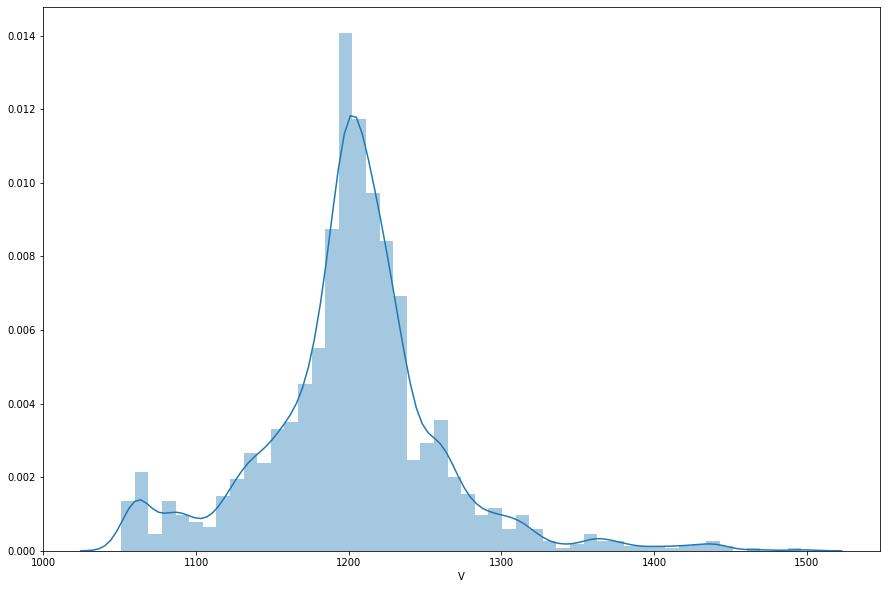

In [12]:
plt.figure(figsize=(15,10))
plt.tight_layout()
seabornInstance.distplot(dataset['V'])

In [13]:
 #
X = dataset2
y = dataset['Distance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
def powerset(seq):
    """
    Returns all the subsets of this set. This is a generator.
    """
    if len(seq) <= 0:
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

In [15]:
allEst = pd.DataFrame({'Model':[0],'Len':[0],'Subset': [' '],'rsquared_adj':[0.0],'AIC':[0],'BIC':[0],'mse_resid':[0],'CV':[0.0],
                      'fvalue':[0],'f_pvalue':[0]})
predictors = ['TimeDiff','Press1','Press2','Winter','Summer']
subsets = [set(s) for s in powerset(predictors)]
lm = LinearRegression()
m = 0
for sb in subsets:
    if len(sb):
        X7 = sm.add_constant(X_train.loc[:,sb])
        #X7 =  X_train.loc[:,sb] 
        est7 = sm.regression.linear_model.OLS(y_train, X7)
        est7 = est7.fit()
        allEst.at[m,'Model'] = m+1
        allEst.at[m,'Len'] = len(sb)
        substr = ', '.join(str(e) for e in sb)
        allEst.at[m,'Subset'] = str(substr)
        allEst.at[m,'rsquared_adj'] = est7.rsquared_adj
        allEst.at[m,'AIC'] = est7.aic
        allEst.at[m,'BIC'] = est7.bic
        scores = cross_val_score(lm, X7, y_train, scoring='r2', cv=10)
        allEst.at[m,'CV'] = scores.mean()
        allEst.at[m,'fvalue'] = est7.fvalue
        allEst.at[m,'f_pvalue'] = est7.f_pvalue
        allEst.at[m,'mse_resid'] = est7.mse_resid
        m = m+1
allEst

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
0,1.0,5.0,"Press2, Press1, Winter, Summer, TimeDiff",0.992026,5950.000000,5981.000000,4.000000,0.991769,34438.000000,0.000000e+00
1,2.0,4.0,"Press1, Press2, Winter, Summer",0.034038,12593.205673,12619.372950,518.576019,0.014320,13.192209,1.502640e-10
2,3.0,4.0,"Press2, TimeDiff, Winter, Summer",0.992024,5949.729440,5975.896717,4.281712,0.991793,43037.155872,0.000000e+00
3,4.0,3.0,"Press2, Winter, Summer",0.011502,12624.150297,12645.084119,530.674579,-0.001144,6.367974,2.760341e-04
4,5.0,4.0,"Press1, Winter, TimeDiff, Summer",0.991994,5954.953320,5981.120597,4.297892,0.991746,42873.837234,0.000000e+00
5,6.0,3.0,"Press1, Winter, Summer",0.033753,12592.617975,12613.551797,518.729197,0.017116,17.115249,6.462479e-11
6,7.0,3.0,"Winter, TimeDiff, Summer",0.991947,5962.047942,5982.981764,4.323074,0.991721,56829.110513,0.000000e+00
7,8.0,2.0,"Winter, Summer",0.008515,12627.331373,12643.031740,532.278041,-0.004897,6.943088,9.993172e-04
8,9.0,4.0,"Press1, Press2, TimeDiff, Summer",0.991964,5960.114479,5986.281756,4.313938,0.991723,42713.083297,0.000000e+00
9,10.0,3.0,"Press1, Press2, Summer",0.026896,12602.411200,12623.345022,522.410088,0.007604,13.751156,7.705220e-09


In [16]:
allEst.to_csv('all_est.csv', encoding='utf-8', index=False)

In [17]:
allEst = pd.DataFrame({'Model':[0],'Len':[0],'Subset': [' '],'rsquared_adj':[0.0],'AIC':[0],'BIC':[0],'mse_resid':[0],'CV':[0.0],
                      'fvalue':[0],'f_pvalue':[0]})
predictors = ['TimeDiff','Press1','Press2','Winter','Summer']
subsets = [set(s) for s in powerset(predictors)]
lm = LinearRegression()
m = 0
for sb in subsets:
    if len(sb):
        X7 = X_train.loc[:,sb]
        #X7 =  sm.add_constant(X_train.loc[:,sb])#
        est7 = sm.regression.linear_model.OLS(y_train, X7)
        est7 = est7.fit()
        allEst.at[m,'Model'] = m+1
        allEst.at[m,'Len'] = len(sb)
        substr = ', '.join(str(e) for e in sb)
        allEst.at[m,'Subset'] = str(substr)
        allEst.at[m,'rsquared_adj'] = est7.rsquared_adj
        allEst.at[m,'AIC'] = est7.aic
        allEst.at[m,'BIC'] = est7.bic
        scores = cross_val_score(lm, X7, y_train, scoring='r2', cv=10)
        allEst.at[m,'CV'] = scores.mean()
        allEst.at[m,'fvalue'] = est7.fvalue
        allEst.at[m,'f_pvalue'] = est7.f_pvalue
        allEst.at[m,'mse_resid'] = est7.mse_resid
        m = m+1

In [18]:
a1 = allEst[allEst['Len'] == 1].sort_values(by='rsquared_adj', ascending=False)
a1

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
30,31.0,1.0,TimeDiff,0.998077,5973.499862,5978.733317,4.368403,0.991675,718683.381766,0.000000e+00
29,30.0,1.0,Press1,0.615526,13310.904040,13316.137495,873.197893,-0.003025,2218.327067,8.851516e-290
27,28.0,1.0,Press2,0.515314,13631.705063,13636.938518,1100.794532,-0.008466,1473.521832,3.946545e-220
15,16.0,1.0,Summer,0.262510,14213.061864,14218.295319,1674.951859,-0.003408,493.990935,7.774734e-94
23,24.0,1.0,Winter,0.051890,14560.998548,14566.232003,2153.301500,-0.011935,76.800731,5.428127e-18


In [19]:
a2 = allEst[allEst['Len'] == 2].sort_values(by='rsquared_adj', ascending=False)
a2

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
14,15.0,2.0,"TimeDiff, Summer",0.998088,5966.431330,5976.898241,4.343031,0.991694,361445.460773,0.000000e+00
22,23.0,2.0,"Winter, TimeDiff",0.998082,5970.343431,5980.810342,4.355316,0.991691,360424.004038,0.000000e+00
28,29.0,2.0,"Press1, TimeDiff",0.998076,5974.672167,5985.139077,4.368950,0.991677,359297.120909,0.000000e+00
26,27.0,2.0,"Press2, TimeDiff",0.998076,5974.856014,5985.322925,4.369530,0.991723,359249.338454,0.000000e+00
13,14.0,2.0,"Press1, Summer",0.629681,13259.950752,13270.417663,841.050408,0.010399,1178.509442,1.723091e-299
21,22.0,2.0,"Press1, Winter",0.625231,13276.494869,13286.961780,851.157176,0.006682,1156.304669,6.662390e-296
25,26.0,2.0,"Press1, Press2",0.617134,13306.098186,13316.565096,869.545832,-0.005872,1117.228357,1.748339e-289
11,12.0,2.0,"Press2, Summer",0.537657,13567.340001,13577.806912,1050.050243,-0.000257,806.306618,7.738338e-233
19,20.0,2.0,"Press2, Winter",0.515016,13633.556254,13644.023165,1101.472127,-0.007304,736.381982,1.764253e-218
7,8.0,2.0,"Winter, Summer",0.314627,14112.554749,14123.021659,1556.585858,-0.004897,318.898620,1.286953e-114


In [20]:
a3 = allEst[allEst['Len'] == 3].sort_values(by='rsquared_adj', ascending=False)
a3

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
6,7.0,3.0,"Winter, TimeDiff, Summer",0.998097,5961.017256,5976.717622,4.322971,0.991721,242084.311790,0.000000e+00
10,11.0,3.0,"Press2, TimeDiff, Summer",0.998091,5965.411040,5981.111406,4.336707,0.991742,241316.079650,0.000000e+00
12,13.0,3.0,"Press1, TimeDiff, Summer",0.998086,5968.381024,5984.081390,4.346016,0.991691,240798.170836,0.000000e+00
18,19.0,3.0,"Press2, TimeDiff, Winter",0.998083,5970.579814,5986.280180,4.352921,0.991756,240415.458465,0.000000e+00
24,25.0,3.0,"Press1, Press2, TimeDiff",0.998082,5971.488349,5987.188715,4.355778,0.991698,240257.499879,0.000000e+00
20,21.0,3.0,"Press1, Winter, TimeDiff",0.998081,5972.341139,5988.041505,4.358460,0.991722,240109.327370,0.000000e+00
5,6.0,3.0,"Press1, Winter, Summer",0.634260,13243.715581,13259.415947,830.650173,0.017116,801.615382,7.502549e-302
9,10.0,3.0,"Press1, Press2, Summer",0.629880,13260.205378,13275.905744,840.598994,0.007604,786.675776,2.796857e-298
17,18.0,3.0,"Press1, Press2, Winter",0.625911,13274.978842,13290.679208,849.613454,0.003527,773.441382,4.429692e-295
3,4.0,3.0,"Press2, Winter, Summer",0.538872,13564.693289,13580.393655,1047.290459,-0.001144,540.502391,2.446168e-232


In [21]:
a4 = allEst[allEst['Len'] == 4].sort_values(by='rsquared_adj', ascending=False)
a4

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
2,3.0,4.0,"Press2, TimeDiff, Winter, Summer",0.998104,5956.385322,5977.319143,4.305435,0.991793,182304.365524,0.000000e+00
4,5.0,4.0,"Press1, Winter, TimeDiff, Summer",0.998097,5961.924074,5982.857896,4.322688,0.991746,181575.390155,0.000000e+00
8,9.0,4.0,"Press1, Press2, TimeDiff, Summer",0.998096,5962.362195,5983.296017,4.324055,0.991723,181517.851791,0.000000e+00
16,17.0,4.0,"Press1, Press2, TimeDiff, Winter",0.998085,5970.148099,5991.081921,4.348432,0.991733,180498.360081,0.000000e+00
1,2.0,4.0,"Press1, Press2, Winter, Summer",0.634249,13244.756081,13265.689902,830.675982,0.014320,601.432122,1.430417e-300


In [22]:
a5 = allEst[allEst['Len'] == 5].sort_values(by='rsquared_adj', ascending=False)
a5

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
0,1.0,5.0,"Press2, Press1, Winter, Summer, TimeDiff",0.998105,5957.0,5983.0,4.0,0.991769,145877.0,0.0


In [23]:
allEstRes = a5.append(a1.iloc[0,:]).append(a2.iloc[0,:]).append(a3.iloc[0,:]).append(a4.iloc[0,:])
allEstRes.sort_values(by='Len')

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
30,31.0,1.0,TimeDiff,0.998077,5973.499862,5978.733317,4.368403,0.991675,718683.381766,0.0
14,15.0,2.0,"TimeDiff, Summer",0.998088,5966.431330,5976.898241,4.343031,0.991694,361445.460773,0.0
6,7.0,3.0,"Winter, TimeDiff, Summer",0.998097,5961.017256,5976.717622,4.322971,0.991721,242084.311790,0.0
2,3.0,4.0,"Press2, TimeDiff, Winter, Summer",0.998104,5956.385322,5977.319143,4.305435,0.991793,182304.365524,0.0
0,1.0,5.0,"Press2, Press1, Winter, Summer, TimeDiff",0.998105,5957.000000,5983.000000,4.000000,0.991769,145877.000000,0.0


In [24]:
Subset1 = ['TimeDiff']
Subset2 = ['Press2', 'TimeDiff']
Subset3 = ['Press2', 'Winter','TimeDiff']
Subset4 = ['Press2', 'Winter', 'Summer', 'TimeDiff']
Subset5 = ['Press2', 'Press1', 'Summer', 'Winter', 'TimeDiff']

In [25]:
X1 = sm.add_constant(X_train[Subset1])
est1 = sm.regression.linear_model.OLS(y_train, X1)
est1 = est1.fit()
print(est1.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 1.694e+05
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:50:08   Log-Likelihood:                -2982.3
No. Observations:                1385   AIC:                             5969.
Df Residuals:                    1383   BIC:                             5979.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3019      0.115      2.625      0.0

In [26]:
X1_0 = X_train[Subset1]
est1_0 = sm.regression.linear_model.OLS(y_train, X1_0)
est1_0 = est1_0.fit()
print(est1_0.summary())

                                 OLS Regression Results                                
Dep. Variable:               Distance   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          7.187e+05
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:50:08   Log-Likelihood:                         -2985.7
No. Observations:                1385   AIC:                                      5973.
Df Residuals:                    1384   BIC:                                      5979.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [27]:
X2 = sm.add_constant(X_train[Subset2])
est2 = sm.regression.linear_model.OLS(y_train, X2)
est2 = est2.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 8.526e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:50:08   Log-Likelihood:                -2977.4
No. Observations:                1385   AIC:                             5961.
Df Residuals:                    1382   BIC:                             5977.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5891      0.147      4.014      0.0

In [28]:
X2_0 = X_train[Subset2]
est2_0 = sm.regression.linear_model.OLS(y_train, X2_0)
est2_0 = est2_0.fit()
print(est2_0.summary())

                                 OLS Regression Results                                
Dep. Variable:               Distance   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          3.592e+05
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:50:08   Log-Likelihood:                         -2985.4
No. Observations:                1385   AIC:                                      5975.
Df Residuals:                    1383   BIC:                                      5985.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
X3 = sm.add_constant(X_train[Subset3])
est3 = sm.regression.linear_model.OLS(y_train, X3)
est3 = est3.fit()
print(est3.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 5.710e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:50:08   Log-Likelihood:                -2973.7
No. Observations:                1385   AIC:                             5955.
Df Residuals:                    1381   BIC:                             5976.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6083      0.147      4.150      0.0

In [30]:
X3_0 = X_train[Subset3]
est3_0 = sm.regression.linear_model.OLS(y_train, X3_0)
est3_0 = est3_0.fit()
print(est3_0.summary())

                                 OLS Regression Results                                
Dep. Variable:               Distance   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          2.404e+05
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:50:08   Log-Likelihood:                         -2982.3
No. Observations:                1385   AIC:                                      5971.
Df Residuals:                    1382   BIC:                                      5986.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [31]:
X4 = sm.add_constant(X_train[Subset4])
est4 = sm.regression.linear_model.OLS(y_train, X4)
est4 = est4.fit()
print(est4.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 4.304e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:50:08   Log-Likelihood:                -2969.9
No. Observations:                1385   AIC:                             5950.
Df Residuals:                    1380   BIC:                             5976.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4586      0.156      2.941      0.0

In [32]:
X4_0 = X_train[Subset4]
est4_0 = sm.regression.linear_model.OLS(y_train, X4_0)
est4_0 = est4_0.fit()
print(est4_0.summary())

                                 OLS Regression Results                                
Dep. Variable:               Distance   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.823e+05
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:50:08   Log-Likelihood:                         -2974.2
No. Observations:                1385   AIC:                                      5956.
Df Residuals:                    1381   BIC:                                      5977.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [33]:
X5 = sm.add_constant(X_train[Subset5])
est5 = sm.regression.linear_model.OLS(y_train, X5)
est5 = est5.fit()
print(est5.summary())

                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.444e+04
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        19:50:08   Log-Likelihood:                -2969.2
No. Observations:                1385   AIC:                             5950.
Df Residuals:                    1379   BIC:                             5982.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6259      0.213      2.944      0.0

In [34]:
X5_0 = X_train[Subset5]
est5_0 = sm.regression.linear_model.OLS(y_train, X5_0)
est5_0 = est5_0.fit()
print(est5_0.summary())

                                 OLS Regression Results                                
Dep. Variable:               Distance   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.459e+05
Date:                Tue, 20 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:50:08   Log-Likelihood:                         -2973.5
No. Observations:                1385   AIC:                                      5957.
Df Residuals:                    1380   BIC:                                      5983.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

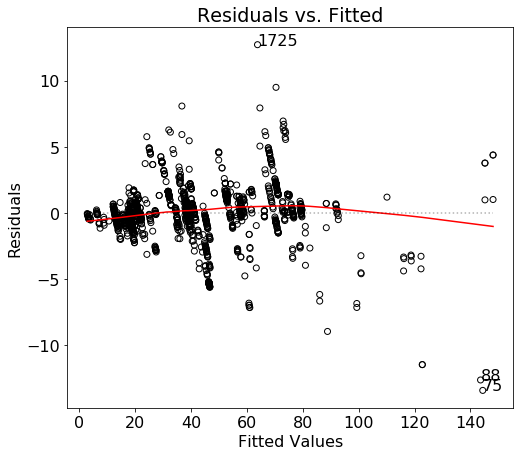

In [35]:
from statsmodels.nonparametric.smoothers_lowess import lowess

residuals = est1.resid
fitted = est1.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

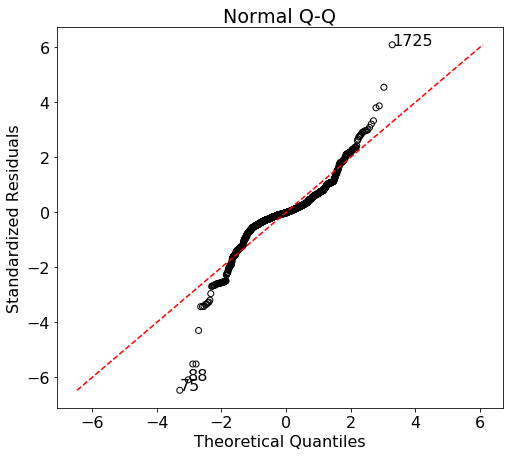

In [36]:
sorted_student_residuals = pd.Series(est1.get_influence().resid_studentized_internal)
sorted_student_residuals.index = est1.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

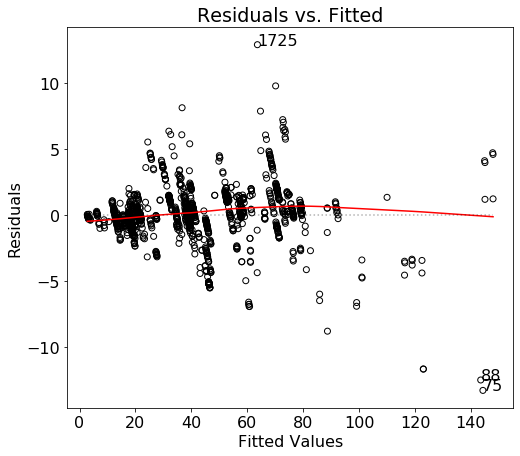

In [37]:
residuals = est2.resid
fitted = est2.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()

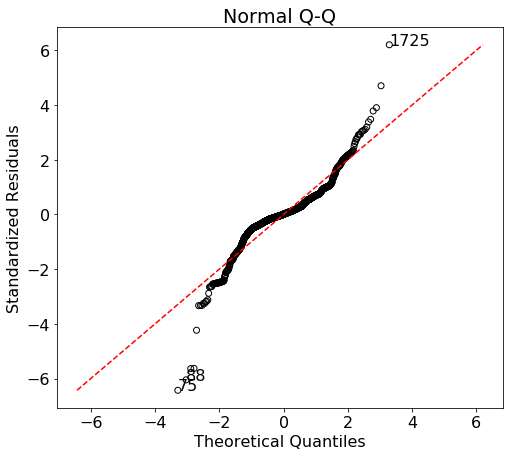

In [38]:
sorted_student_residuals = pd.Series(est2.get_influence().resid_studentized_internal)
sorted_student_residuals.index = est2.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

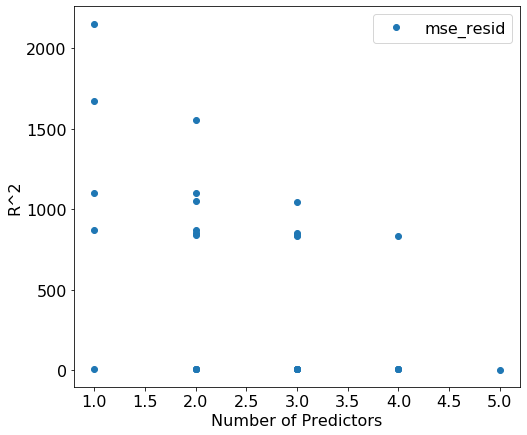

In [39]:
allEst.plot(x='Len', y='mse_resid', style='o')  
#plt.title('Press2 vs V')  
plt.xlabel('Number of Predictors')  
plt.ylabel('R^2')  
plt.show()

In [40]:
best_subset = allEstRes

In [41]:
best_subset

,Model,Len,Subset,rsquared_adj,AIC,BIC,mse_resid,CV,fvalue,f_pvalue
0,1.0,5.0,"Press2, Press1, Winter, Summer, TimeDiff",0.998105,5957.000000,5983.000000,4.000000,0.991769,145877.000000,0.0
30,31.0,1.0,TimeDiff,0.998077,5973.499862,5978.733317,4.368403,0.991675,718683.381766,0.0
14,15.0,2.0,"TimeDiff, Summer",0.998088,5966.431330,5976.898241,4.343031,0.991694,361445.460773,0.0
6,7.0,3.0,"Winter, TimeDiff, Summer",0.998097,5961.017256,5976.717622,4.322971,0.991721,242084.311790,0.0
2,3.0,4.0,"Press2, TimeDiff, Winter, Summer",0.998104,5956.385322,5977.319143,4.305435,0.991793,182304.365524,0.0


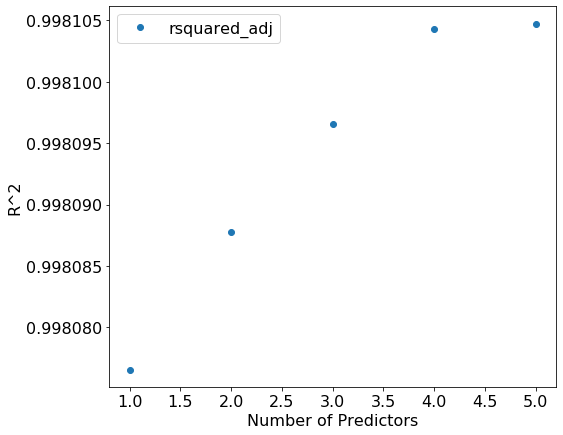

In [42]:
best_subset.plot(x='Len', y='rsquared_adj', style='o')  
#plt.title('Press2 vs V')  
plt.xlabel('Number of Predictors')  
plt.ylabel('R^2')  
plt.show()

In [43]:
X1_test = sm.add_constant(X_test[Subset1])
X1_0_test = X_test[Subset1]
X2_test = sm.add_constant(X_test[Subset2])
X2_0_test = X_test[Subset2]
X3_test = sm.add_constant(X_test[Subset3])
X3_0_test = X_test[Subset3]
X4_test = sm.add_constant(X_test[Subset4])
X4_0_test = X_test[Subset4]
X5_test = sm.add_constant(X_test[Subset5])
X5_0_test = X_test[Subset5]

In [44]:
y_pred1 = est1.predict(X1_test)
y_pred1_0 = est1_0.predict(X1_0_test)
y_pred2 = est2.predict(X2_test)
y_pred2_0 = est2_0.predict(X2_0_test)
y_pred3 = est3.predict(X3_test)
y_pred3_0 = est3_0.predict(X3_0_test)
y_pred4 = est4.predict(X4_test)
y_pred4_0 = est4_0.predict(X4_0_test)
y_pred5 = est5.predict(X5_test)
y_pred5_0 = est5_0.predict(X5_0_test)

In [45]:
df = pd.DataFrame({'Actual': y_test, 'Predicted1': y_pred1, 'Predicted1_0': y_pred1_0,'Predicted2': y_pred2, 'Predicted2_0': y_pred2_0,'Predicted3': y_pred3, 'Predicted3_0': y_pred3_0
                  ,'Predicted4': y_pred4, 'Predicted4_0': y_pred4_0,'Predicted5': y_pred5, 'Predicted5_0': y_pred5_0})
df

,Actual,Predicted1,Predicted1_0,Predicted2,Predicted2_0,Predicted3,Predicted3_0,Predicted4,Predicted4_0,Predicted5,Predicted5_0
1413,21.07,20.623595,20.434848,20.746799,20.423529,20.733378,20.401312,20.588694,20.315221,20.659273,20.336548
249,53.75,56.168350,56.177534,56.254026,56.196504,56.227373,56.170077,56.104740,56.021613,55.956424,56.152053
220,12.60,13.463097,13.234477,13.287320,13.155464,13.222553,13.091486,13.381241,13.352713,13.324940,13.401422
1076,58.44,57.792319,57.810547,57.586471,57.772670,57.508149,57.705767,57.695222,57.895126,57.683773,57.850226
1658,72.58,66.740256,66.808311,66.922603,66.857956,66.911014,66.845265,66.800631,66.716405,66.642235,66.854497
...,...,...,...,...,...,...,...,...,...,...,...
554,69.70,70.343773,70.431894,70.568897,70.493969,70.564174,70.487326,70.782476,70.811845,70.754666,70.824326
1305,10.60,10.611307,10.366807,10.479898,10.293673,10.423480,10.235782,10.582581,10.516647,10.642953,10.490133
1406,72.58,70.343773,70.431894,70.568897,70.493969,70.564174,70.487326,70.782476,70.811845,70.754666,70.824326
317,18.08,18.895816,18.697448,19.034608,18.687422,19.024256,18.667323,18.879226,18.589134,18.919923,18.636708


In [46]:
df.to_csv('prediction.csv', encoding='utf-8', index=False)

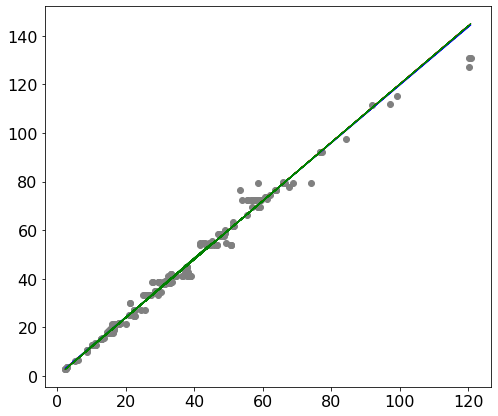

In [47]:
plt.scatter(X_test['TimeDiff'], df['Actual'],  color='gray')
plt.plot(X_test['TimeDiff'], y_pred1, color='blue', linewidth=1)
plt.plot(X_test['TimeDiff'], y_pred2_0, color='red', linewidth=1)
plt.plot(X_test['TimeDiff'], y_pred3_0, color='green', linewidth=1)
plt.show()

In [48]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1)))

Mean Absolute Error: 1.464825782527764
Mean Squared Error: 6.460539494523786
Root Mean Squared Error: 2.541759133852731


In [49]:
# sum of square of residuals
ssr = np.sum((y_pred1 - y_test)**2)

#  total sum of squares
sst = np.sum((y_test - np.mean(y_test))**2)

# R2 score
r2_score = 1 - (ssr/sst)

In [50]:
r2_score

0.9875694386274998

In [51]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred1_0))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred1_0))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred1_0)))

Mean Absolute Error: 1.4562067983731017
Mean Squared Error: 6.569650543559151
Root Mean Squared Error: 2.5631329547175565


In [52]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

Mean Absolute Error: 1.465760623302953
Mean Squared Error: 6.390238089197861
Root Mean Squared Error: 2.5278920248297516


In [53]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred2_0))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred2_0))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred2_0)))

Mean Absolute Error: 1.4577440841639362
Mean Squared Error: 6.577208349898612
Root Mean Squared Error: 2.564606860690077


In [54]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred3))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred3))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred3)))

Mean Absolute Error: 1.4593079879374324
Mean Squared Error: 6.339155218309748
Root Mean Squared Error: 2.517767903979584


In [55]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred3_0))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred3_0))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred3_0)))

Mean Absolute Error: 1.454028719765732
Mean Squared Error: 6.535808652438556
Root Mean Squared Error: 2.556522765875273


In [56]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred4))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred4))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred4)))

Mean Absolute Error: 1.4613045396561823
Mean Squared Error: 6.290391078957225
Root Mean Squared Error: 2.5080652062809743


In [57]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred4_0))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred4_0))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred4_0)))

Mean Absolute Error: 1.4684341991978362
Mean Squared Error: 6.4056284679622575
Root Mean Squared Error: 2.5309343073185953


In [58]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred5))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred5))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred5)))

Mean Absolute Error: 1.4665939220777502
Mean Squared Error: 6.350690551177825
Root Mean Squared Error: 2.520057648383827


In [59]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred5_0))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred5_0))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred5_0)))

Mean Absolute Error: 1.4614531007691478
Mean Squared Error: 6.331670330437097
Root Mean Squared Error: 2.516281051559443


### Under 25 km

In [60]:
df_25 = df[df['Actual'] < 25]

In [61]:
y_25 = df_25['Actual']
y_pred_25 = df_25['Predicted3_0']

In [62]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_25, y_pred_25))  
print('Mean Squared Error:', metrics.mean_squared_error(y_25, y_pred_25))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_25, y_pred_25)))

Mean Absolute Error: 0.5366777357810917
Mean Squared Error: 0.6023503302496882
Root Mean Squared Error: 0.7761123180633639


## 25 - 50 km

In [63]:
df_50 = df[(df['Actual'] >= 25) & (df['Actual'] < 50)]
y_50 = df_50['Actual']
y_pred_50 = df_50['Predicted3_0']

In [64]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_50, y_pred_50))  
print('Mean Squared Error:', metrics.mean_squared_error(y_50, y_pred_50))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_50, y_pred_50)))

Mean Absolute Error: 1.393971703777877
Mean Squared Error: 4.061604501478754
Root Mean Squared Error: 2.015342278988548
